In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib notebook

In [18]:
text_data = pd.read_csv('dataset.dat', sep=' ')
text_data_x = text_data.loc[:,'x1':'x5'].copy()
text_data_y = text_data.loc[:,'y'].copy()

<IPython.core.display.Javascript object>


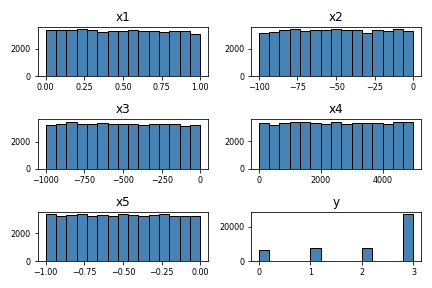

In [19]:
text_data.hist(bins=15, color='steelblue', edgecolor='black', 
               linewidth=1.0, xlabelsize=8, ylabelsize=8, grid=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


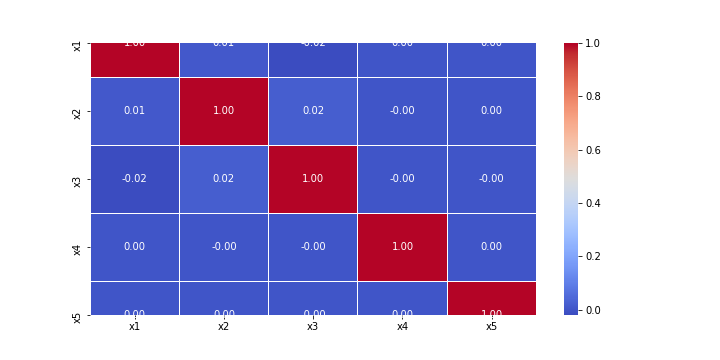

In [28]:
f, ax = plt.subplots(figsize=(10, 5))
corr = text_data_x.corr()
hm = sns.heatmap(round(corr,2), annot=True, ax=ax, cmap="coolwarm",fmt='.2f', linewidths=.05)

In [81]:
import numpy as np
import random as rd
import time as tm
import pandas as pd
import sklearn.model_selection as ms

class NeuralNetwork:
    def __init__(self, layers:list):
        self.layers = layers
        self.L = len(layers)
        self.w = [
                np.random.randn(next_layer, back_layer + 1)
            for next_layer, back_layer in zip(layers[1:], layers[:-1])
        ]

    def feedforward(self, x):
        z = []; a = [self.add_bias(x)]

        for l in range(1, self.L):
            z_l = np.dot(self.w[l-1], a[l-1])
            a_l = self.sigmoid(z_l)
            if l < self.L - 1: a_l = self.add_bias(a_l) 
            z.append(z_l); a.append(a_l)
        
        return (z, a)

    def add_bias(self, a):
        """
        add a_0 = 1 as input for bias w_0
        """
        return np.insert(a, 0, 1, axis=0)

    def sigmoid(self, z):
        """
        Sigmoid function use as activation function
        """
        return 1.0 / (1.0 + np.exp(-z))
    
    def sigmoid_gradient(self, z):
        g = self.sigmoid(z)
        return g * (1 - g)

    def predict(self, x):
        _, a = self.feedforward(x)
        return np.argmax(a[-1])

    def evaluate(self, test_data):
        """
        Evaluate NN with test data.
        This will return the number of correct result
        """
        results = [(self.predict(x), y) for (x, y) in test_data]
        return sum(int(_y == y) for (_y, y) in results)

    def cost(self, data):
        """
        Return cost of NN on test data
        """
        cost = 0

        for x, y in data:
            _, a = self.feedforward(x)
            output = a[-1]

            cost += np.sum(np.nan_to_num(
                y*np.log(output) + \
                (1 - y)*np.log(1 - output)
            ))
            
        return -cost / len(data)

    def backpropagation(self, x, y):
        """
        Backpropagation to calc derivatives
        """
        w_grad = [np.zeros(W.shape) for W in self.w]
        # feedforward
        z, a = self.feedforward(x)
        # backward
        dz = a[-1] - y
        for l in range(-1, -self.L, -1):
            if l < -1:
                da = self.sigmoid_gradient(z[l])
                dz = np.dot(self.w[l+1][:, 1:].T, dz) * da
            
            w_grad[l] = np.dot(dz, a[l-1].transpose())
        
        return w_grad

    def check_gradient(self, data, grad, epsilon=1e-4, threshold=1e-5):
        """
        Check gradient with:
        * Epsilon   n: 1e-4
        * Threshold : 1e-6
        """
        for l in range(self.L - 1):
            n_row, n_col = self.w[l].shape
            for i in range(n_row):
                for j in range(n_col):
                    w_l_ij = self.w[l][i][j]

                    self.w[l][i][j] = w_l_ij - epsilon
                    l_cost = self.cost(data) # left

                    self.w[l][i][j] = w_l_ij + epsilon
                    r_cost = self.cost(data) # right

                    numerical_grad = (r_cost - l_cost) / (2 * epsilon)
                    diff = abs(grad[l][i][j] - numerical_grad)

                    self.w[l][i][j] = w_l_ij # reset w

                    if diff > threshold:
                        print('Check Grad Error at (l: {0}, col: {1}, row: {2}), | numerical_grad: {3} vs backprop grad: {4} | : {5}'
                              .format(l, i, j, numerical_grad, grad[l][i][j], diff))
                        return False
        
        return True

    def train(self, train_data, epochs, mini_batch_size, eta):
        """
        Train NN with train data ``[(x, y)]``.
        This use mini-batch SGD method to train the NN.
        """
        # cost of layers
        cost = list()
        
        for j in range(epochs):
            start_time = tm.time()
            print('Epoch {0} begin...'.format(j + 1))
            # shuffle data before run
            rd.shuffle(train_data)
            # divide data into mini batchs
            for k in range(0, len(train_data), mini_batch_size):
                mini_batch = train_data[k:k+mini_batch_size]
                m_mini_batch = len(mini_batch) 
                # calc gradient
                w_grad = [np.zeros(W.shape) for W in self.w]
                for x, y in mini_batch:
                    grad = self.backpropagation(x, y)
                    w_grad = [w + g for w, g in zip(w_grad, grad)]
                w_grad = [w / m_mini_batch for w in w_grad]
                # check grad for first mini_batch in first epoch
                if j == 0  and k == 0 and not self.check_gradient(mini_batch, w_grad):
                    print('backprop fail!')
                    return False
                # update w
                self.w = [W - eta * W_grad for W, W_grad in zip(self.w, w_grad)]
            # calc cost
            cost.append(self.cost(train_data))
            print('Epoch {0} done: {1}'.format(j + 1, tm.time() - start_time))
        
        return cost

In [82]:
##### READ DATASET #####
dataset = pd.read_csv('./dataset.dat', delimiter=' ')
mean = dataset.loc[:,'x1':'x5'].mean()
max = dataset.loc[:,'x1':'x5'].max()
min = dataset.loc[:,'x1':'x5'].min()
dataset.loc[:,'x1':'x5'] = ( dataset.loc[:,'x1':'x5'] - mean ) / (max - min)
# Split data (training set, testing set)
train_data, test_data = ms.train_test_split(dataset)

In [83]:
# input - x1,...,x5
X = train_data.loc[:,'x1':'x5']
# output - one hot vector
Y = pd.Categorical(train_data['y'])
Y = pd.get_dummies(Y)

# Convert to list of arrays
X =  [np.array([x]).T for x in X.values.tolist()]
Y =  [np.array([y]).T for y in Y.values.tolist()]

# Link output and input
train_data = list(zip(X, Y))

In [84]:
# input - x1,...,x5
X = test_data.loc[:,'x1':'x5']
# output - one hot vector
Y = test_data['y']

# Convert to list of arrays
X =  [np.array([x]).T for x in X.values.tolist()]
Y =  [np.array([y]).T for y in Y.values.tolist()]

# Link output and input
test_data = list(zip(X, Y))

In [96]:
##### TRAIN MODEL #####
import time
nn = NeuralNetwork([5, 6, 4])
start = time.time()
nn.train(train_data, 10, 50, 1.5)
end = time.time()
correct = nn.evaluate(test_data)
total = len(test_data)
print('Evaluation: {0} / {1} = {2}%'.format(correct, total, 100 * correct/total))
print('Total time is {0}'.format(end-start))

Epoch 1 begin...
Epoch 1 done: 6.8641557693481445
Epoch 2 begin...
Epoch 2 done: 6.211814880371094
Epoch 3 begin...
Epoch 3 done: 6.2297682762146
Epoch 4 begin...
Epoch 4 done: 6.2635817527771
Epoch 5 begin...
Epoch 5 done: 6.2705299854278564
Epoch 6 begin...
Epoch 6 done: 6.2678163051605225
Epoch 7 begin...
Epoch 7 done: 6.280646085739136
Epoch 8 begin...
Epoch 8 done: 6.26973557472229
Epoch 9 begin...
Epoch 9 done: 6.295882940292358
Epoch 10 begin...
Epoch 10 done: 6.265366554260254
Evaluation: 11385 / 12382 = 91.94798901631401%
Total time is 63.220216035842896
